In [2]:
import pickle, re, os, keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from scipy.stats import rankdata

import warnings
warnings.filterwarnings("ignore")

2025-03-13 10:36:11.662145: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def kernel_mse_loss(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true, y_pred) 

keras.utils.get_custom_objects()["kernel_mse_loss"] = kernel_mse_loss

In [4]:
with open('./Results/Results_2.pkl', 'rb') as f:    
    results = pickle.load(f)

In [5]:
results.keys()

dict_keys([('Argone', 0.0), ('Argone', 0.001), ('Argone', 0.002), ('Argone', 0.005), ('Argone', 0.007), ('Argone', 0.01), ('Argone', 0.02), ('Beijing', 0.0), ('Beijing', 0.001), ('Beijing', 0.002), ('Beijing', 0.005), ('Beijing', 0.007), ('Beijing', 0.01), ('Beijing', 0.02), ('Chengdu', 0.0), ('Chengdu', 0.001), ('Chengdu', 0.002), ('Chengdu', 0.005), ('Chengdu', 0.007), ('Chengdu', 0.01), ('Chengdu', 0.02)])

In [6]:
def filterTitle(value):
    value = re.sub(r"_\w+", "", value) 
    value = re.sub(r"RNNSimple", "SRNN", value) 
    return value

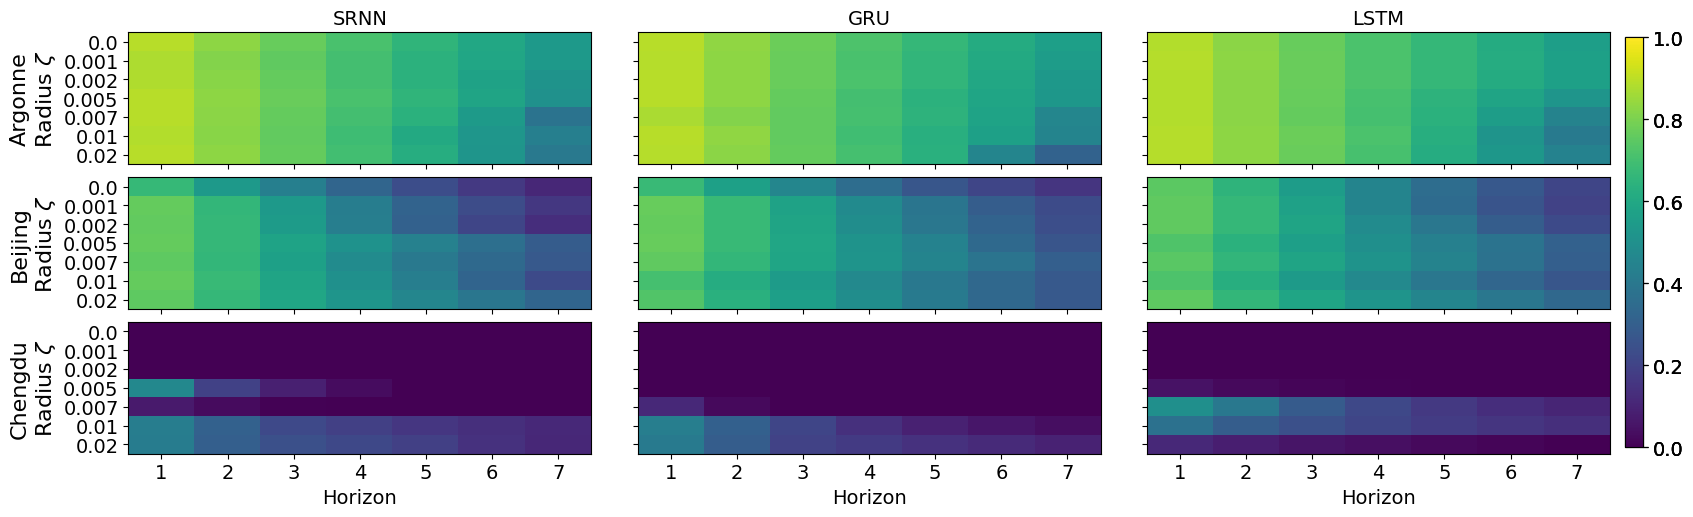

In [7]:
metric = 'R2'
datasets = ['Argone', 'Beijing', 'Chengdu']
models = ['RNNSimple_Model', 'GRU_Model', 'LSTM_Model']
thresholds = [0.0, 0.001, 0.002, 0.005, 0.007, 0.01, 0.02]
first_dataset = datasets[0]
first_model = models[0]
first_threshold = thresholds[0]
num_horizons = len(results[(first_dataset, first_threshold)][first_model]['Global'][f"{metric} Global"])
horizons = range(1, num_horizons + 1)  

fig, axes = plt.subplots(3, 3, figsize=(18, 5), sharex=True,sharey=True)

for d_,data in enumerate(datasets):
   
    im_obj = None
    
    for idx, model in enumerate(models):
        matrix = np.zeros((len(thresholds), num_horizons))
        for i, thr in enumerate(thresholds):
            valores = results[(data, thr)][model]['Global'][f"{metric} Global"]
            matrix[i, :] = valores
        
        ax = axes[d_,idx]
        if metric == 'R2':
            vmax_=1
            index = np.argmax(matrix, axis=0)                
        if metric == 'MAPE':
            vmax_=100
            index = np.argmin(matrix, axis=0)                
        if metric == 'MAE':
            vmax_= 4
            index = np.argmin(matrix, axis=0)                
        
        im_obj = ax.imshow(matrix, cmap='viridis', aspect='auto', vmin=0, vmax=vmax_)
    
    cbar_ax = fig.add_axes([0.85, 0.09, 0.01, 0.82])  
    fig.colorbar(im_obj, cax=cbar_ax)
    cbar_ax.tick_params(labelsize=14)
    
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    filename = os.path.join("/kaggle/working/", f"{data}_{metric}.pdf")



axes[0,0].set_title('SRNN',fontsize=14)
axes[0,0].set_yticks(np.arange(len(thresholds)))
axes[0,0].set_yticklabels(thresholds, fontsize=14)
axes[0,0].set_ylabel('Argonne'+"\n" "Radius $\zeta$", fontsize=16)

axes[0,1].set_title('GRU',fontsize=14)
axes[1,0].set_ylabel(datasets[1]+"\n" "Radius $\zeta$", fontsize=16)

axes[1,0].set_yticks(np.arange(len(thresholds)))
axes[1,0].set_yticklabels(thresholds, fontsize=14)

axes[0,2].set_title('LSTM',fontsize=14)

axes[2,0].set_ylabel(datasets[2]+"\n" "Radius $\zeta$", fontsize=16)
axes[2,0].set_yticks(np.arange(len(thresholds)))
axes[2,0].set_yticklabels(thresholds, fontsize=14)
for i in range(len(datasets)):
    axes[2,i].set_xlabel("Horizon",fontsize=14)
    axes[2,i].set_xticks(np.arange(7))
    axes[2,i].set_xticklabels(np.arange(1,8),fontsize=14)

fig.subplots_adjust(hspace=0.1, wspace=0.1)

filename_ = f"./Results/{metric}_Ths.pdf"
plt.savefig(filename_, dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
from scipy.stats import rankdata, friedmanchisquare
from tabulate import tabulate

# Configuraciones del experimento
metric = 'R2'  # O 'MAPE'
datasets = ['Argone', 'Beijing', 'Chengdu']
models = ['RNNSimple_Model', 'GRU_Model', 'LSTM_Model']
thresholds = [0.0, 0.001, 0.002, 0.005, 0.007, 0.01, 0.02]

# Determinar el número de horizontes (se asume que todos tienen la misma cantidad)
first_dataset = datasets[0]
first_model = models[0]
first_threshold = thresholds[0]
num_horizons = len(results[(first_dataset, first_threshold)][first_model]['Global'][f"{metric} Global"])


table_data = []
# Para cada dataset se creará una tabla de ranking de Friedman
for data in datasets:
    print(f"\n=== Dataset: {data} ===")
    
    # 1. Seleccionar el mejor umbral (excluyendo 0.0) para cada modelo,
    best_threshold = {}  # almacenará para cada modelo el mejor umbral
    for model in models:
        avg_perfs = []
        for thr in thresholds[1:]:  # se omite el 0.0
            perf_values = results[(data, thr)][model]['Global'][f"{metric} Global"]
            avg = np.mean(perf_values)
            avg_perfs.append(avg)
        # Para MAE o MAPE, se selecciona el umbral con menor promedio
        if metric == "MAE" or "MAPE":
            best_thr = thresholds[1:][np.argmin(avg_perfs)]
            best_threshold[model] = best_thr
        if metric == "R2":
            best_thr = thresholds[1:][np.argmax(avg_perfs)]
            best_threshold[model] = best_thr
        print(f"{model}: {best_thr}")
    
    # 2. Para cada horizonte, extraer los valores de desempeño para cada configuración:
    #    (modelo con umbral 0.0 y modelo con el mejor umbral)
    # Se crearán 6 columnas en el siguiente orden:
    # [RNNSimple (0.0), RNNSimple (best), GRU (0.0), GRU (best), LSTM (0.0), LSTM (best)]
    ranking_matrix = []  # cada fila corresponde a un horizonte (1 a num_horizons)
    # Además, guardaremos los rankings de cada configuración para calcular la desviación estándar (std)
    ranking_values = { 
        "RNNSimple (0.0)": [],
        "RNNSimple (best)": [],
        "GRU (0.0)": [],
        "GRU (best)": [],
        "LSTM (0.0)": [],
        "LSTM (best)": []
    }
    
    a = []
    for h in range(num_horizons):
        # Extraer desempeño para cada configuración
        perf_rnn0    = results[(data, 0.0)]   ['RNNSimple_Model']['Global'][f"{metric} Global"][h]
        perf_rnnbest = results[(data, best_threshold['RNNSimple_Model'])]['RNNSimple_Model']['Global'][f"{metric} Global"][h]
        perf_gru0    = results[(data, 0.0)]   ['GRU_Model']       ['Global'][f"{metric} Global"][h]
        perf_grubest = results[(data, best_threshold['GRU_Model'])]       ['GRU_Model']       ['Global'][f"{metric} Global"][h]
        perf_lstm0   = results[(data, 0.0)]   ['LSTM_Model']      ['Global'][f"{metric} Global"][h]
        perf_lstmbest= results[(data, best_threshold['LSTM_Model'])]       ['LSTM_Model']      ['Global'][f"{metric} Global"][h]
        
        # Para MAE o MAPE, el menor valor es mejor, por lo que se calcula el ranking sin invertir el signo
        perf_list = [perf_rnn0, perf_rnnbest, perf_gru0, perf_grubest, perf_lstm0, perf_lstmbest]
        a.append(perf_list)

        ranks = rankdata(np.array(perf_list), method='average')
        ranking_matrix.append(ranks)
        
        # Guardamos el ranking por configuración
        ranking_values["RNNSimple (0.0)"].append(ranks[0])
        ranking_values["RNNSimple (best)"].append(ranks[1])
        ranking_values["GRU (0.0)"].append(ranks[2])
        ranking_values["GRU (best)"].append(ranks[3])
        ranking_values["LSTM (0.0)"].append(ranks[4])
        ranking_values["LSTM (best)"].append(ranks[5])
    
    ranking_matrix = np.array(ranking_matrix)  # num_horizons x 6
    metric_values = np.array(a)

    print(ranking_matrix)
    print(metric_values)

    stat, p_value = friedmanchisquare(*metric_values.T)

    print(stat, p_value)

    #print(best_threshold)

    value_rank = np.mean(ranking_matrix, axis=0)
    value_std = np.std(ranking_matrix, axis=0)

    #print(value_rank, value_std)

    headers = ["Dataset", "SRNN", f"SRNN (best)", "GRU", "GRU (best)", "LSTM", "LSTM (best)", "p-value"]

    row = [data, 
           f"{value_rank[0]:.2f} ± {value_std[0]:.2f}" , 
           f"{value_rank[1]:.2f} ± {value_std[1]:.2f}", 
           f"{value_rank[2]:.2f} ± {value_std[2]:.2f}", 
           f"{value_rank[3]:.2f} ± {value_std[3]:.2f}", 
           f"{value_rank[4]:.2f} ± {value_std[4]:.2f}",
           f"{value_rank[5]:.2f} ± {value_std[5]:.2f}", 
           f"{p_value}"]

    table_data.append(row)

table_str = tabulate(table_data, headers, tablefmt="grid")

print(table_str)


=== Dataset: Argone ===
RNNSimple_Model: 0.005
GRU_Model: 0.001
LSTM_Model: 0.001
[[4. 6. 5. 3. 1. 2.]
 [3. 5. 6. 4. 1. 2.]
 [1. 5. 6. 3. 2. 4.]
 [1. 3. 6. 2. 4. 5.]
 [2. 1. 5. 3. 4. 6.]
 [2. 1. 5. 3. 4. 6.]
 [2. 1. 5. 3. 4. 6.]]
[[0.89091626 0.89253347 0.89177098 0.88930003 0.88558606 0.88730557]
 [0.82903118 0.83171535 0.83265297 0.82910545 0.82752414 0.82829057]
 [0.76926503 0.77245559 0.77483422 0.77112789 0.7693856  0.77243716]
 [0.71111048 0.71466181 0.72076367 0.71335642 0.71543647 0.71833081]
 [0.65497198 0.65417355 0.66593123 0.65976286 0.66445748 0.66675108]
 [0.59773265 0.58454553 0.61446459 0.60659738 0.61335466 0.61826126]
 [0.54139301 0.5050802  0.5652134  0.55319151 0.56217909 0.56908828]]
14.428571428571416 0.013104466343130937

=== Dataset: Beijing ===
RNNSimple_Model: 0.02
GRU_Model: 0.007
LSTM_Model: 0.02
[[1. 5. 2. 6. 3. 4.]
 [1. 6. 2. 5. 3. 4.]
 [1. 6. 2. 5. 3. 4.]
 [1. 6. 2. 5. 3. 4.]
 [1. 6. 2. 4. 3. 5.]
 [1. 5. 2. 4. 3. 6.]
 [1. 5. 2. 4. 3. 6.]]
[[0.66974906 0.

In [41]:
value_rank.shape[0]

6